In [1]:
import datetime
import glob
import json
import os
from collections import defaultdict
from pathlib import Path
import traceback

import awkward as ak
import dask
import dask_awkward as dak
import hist.dask
import coffea
import numpy as np
import uproot
from dask.distributed import Client
import matplotlib.pyplot as plt

from coffea.nanoevents import NanoEventsFactory, PHYSLITESchema
from coffea import dataset_tools

import time
import warnings

warnings.filterwarnings("ignore")

from input_files import utils

from dask.distributed import LocalCluster, Client, progress, performance_report

# local: single thread, single worker
# cluster = LocalCluster(n_workers=1, processes=False, threads_per_worker=1)
# client = Client(cluster)

# for UChicago
# update this to point to your own client!
client = Client("tcp://dask-alheld-9412929c-8.af-jupyter:8786")

print(f"awkward: {ak.__version__}")
print(f"dask-awkward: {dak.__version__}")
print(f"uproot: {uproot.__version__}")
print(f"hist: {hist.__version__}")
print(f"coffea: {coffea.__version__}")

awkward: 2.6.3
dask-awkward: 2024.3.0
uproot: 5.3.2
hist: 2.7.2
coffea: 2024.4.1


In [2]:
# -------------------
# INPUT CONFIGURATION
# -------------------
# modify this to change how many files are being processed
# top-level processes determine containers/DSIDs, which each have some number of files
# full list is list(find_containers.container_dict.keys()) + ["data15_13TeV", "data16_13TeV", "data17_13TeV", "data18_13TeV"]

PROCESSES_TO_USE = ["ttbar"]  # 6.7 TB
# PROCESSES_TO_USE = ["db", "zjets", "wjets", "ttV", "othertop", "ttbar"]  # all simulation, 48.4 TB
# PROCESSES_TO_USE = ["db", "zjets", "wjets", "ttV", "othertop", "ttbar", "data15_13TeV", "data16_13TeV", "data17_13TeV", "data18_13TeV"]  # 191 TB

fileset = utils.get_fileset(PROCESSES_TO_USE, max_files_per_container=10, max_containers_per_dsid=None, max_dsid_per_process=None)

# example for how to veto files
# files_to_veto = [("root://192.170.240.143//root://fax.mwt2.org:1094//pnfs/uchicago.edu/atlaslocalgroupdisk/rucio/mc20_13TeV/6e/cf/DAOD_PHYSLITE.37230006._000001.pool.root.1", "CollectionTree")]
# fileset = dataset_tools.filter_files(fileset, lambda x: x not in files_to_veto)

fileset summary
 - number of files: 30
cannot determine total size / number of events when max_files_per_container is being used


In [3]:
# check for files not yet replicated to MWT2
files_at_mwt2 = 0
files_elsewhere = 0
for process in fileset.keys():
    for file in fileset[process]["files"]:
        if "mwt2" in file:
            files_at_mwt2 += 1
        else:
            files_elsewhere += 1

print(f"files at MWT2: {files_at_mwt2}, elsewhere: {files_elsewhere}")

files at MWT2: 30, elsewhere: 0


## Dask distributing `uproot.open`

In [4]:
# turn fileset into simple list of files to run over
all_files = []
for process in fileset:
    all_files += fileset[process]["files"]

# define work to be done
def uproot_open_materialize(fname):
    BRANCH_LIST = [
        "AnalysisJetsAuxDyn.pt", "AnalysisJetsAuxDyn.eta", "AnalysisJetsAuxDyn.phi", "AnalysisJetsAuxDyn.m",
        "AnalysisElectronsAuxDyn.pt", "AnalysisElectronsAuxDyn.eta", "AnalysisElectronsAuxDyn.phi",
        "AnalysisElectronsAuxDyn.m", "AnalysisMuonsAuxDyn.pt", "AnalysisMuonsAuxDyn.eta",
        "AnalysisMuonsAuxDyn.phi", "AnalysisJetsAuxDyn.EnergyPerSampling", "AnalysisJetsAuxDyn.SumPtTrkPt500",
        "AnalysisJetsAuxDyn.TrackWidthPt1000", "PrimaryVerticesAuxDyn.z", "PrimaryVerticesAuxDyn.x",
        "PrimaryVerticesAuxDyn.y", "AnalysisJetsAuxDyn.NumTrkPt500", "AnalysisJetsAuxDyn.NumTrkPt1000",
        "AnalysisJetsAuxDyn.SumPtChargedPFOPt500", "AnalysisJetsAuxDyn.Timing",
        "AnalysisJetsAuxDyn.JetConstitScaleMomentum_eta", "AnalysisJetsAuxDyn.ActiveArea4vec_eta",
        "AnalysisJetsAuxDyn.DetectorEta", "AnalysisJetsAuxDyn.JetConstitScaleMomentum_phi",
        "AnalysisJetsAuxDyn.ActiveArea4vec_phi", "AnalysisJetsAuxDyn.JetConstitScaleMomentum_m",
        "AnalysisJetsAuxDyn.JetConstitScaleMomentum_pt", "AnalysisJetsAuxDyn.EMFrac",
        "AnalysisJetsAuxDyn.Width", "AnalysisJetsAuxDyn.ActiveArea4vec_m", "AnalysisJetsAuxDyn.ActiveArea4vec_pt",
        "AnalysisJetsAuxDyn.DFCommonJets_QGTagger_TracksWidth", "AnalysisJetsAuxDyn.PSFrac",
        "AnalysisJetsAuxDyn.JVFCorr", "AnalysisJetsAuxDyn.DFCommonJets_QGTagger_TracksC1",
        "AnalysisJetsAuxDyn.DFCommonJets_fJvt", "AnalysisJetsAuxDyn.DFCommonJets_QGTagger_NTracks",
        "AnalysisJetsAuxDyn.GhostMuonSegmentCount", "AnalysisMuonsAuxDyn.muonSegmentLinks",
        "AnalysisMuonsAuxDyn.msOnlyExtrapolatedMuonSpectrometerTrackParticleLink",
        "AnalysisMuonsAuxDyn.extrapolatedMuonSpectrometerTrackParticleLink",
        "AnalysisMuonsAuxDyn.inDetTrackParticleLink", "AnalysisMuonsAuxDyn.muonSpectrometerTrackParticleLink",
        "AnalysisMuonsAuxDyn.momentumBalanceSignificance", "AnalysisMuonsAuxDyn.topoetcone20_CloseByCorr",
        "AnalysisMuonsAuxDyn.scatteringCurvatureSignificance", "AnalysisMuonsAuxDyn.scatteringNeighbourSignificance",
        "AnalysisMuonsAuxDyn.neflowisol20_CloseByCorr", "AnalysisMuonsAuxDyn.topoetcone20",
        "AnalysisMuonsAuxDyn.topoetcone30", "AnalysisMuonsAuxDyn.topoetcone40", "AnalysisMuonsAuxDyn.neflowisol20",
        "AnalysisMuonsAuxDyn.segmentDeltaEta", "AnalysisMuonsAuxDyn.DFCommonJetDr",
        "AnalysisMuonsAuxDyn.combinedTrackParticleLink", "AnalysisMuonsAuxDyn.InnerDetectorPt",
        "AnalysisMuonsAuxDyn.MuonSpectrometerPt", "AnalysisMuonsAuxDyn.clusterLink",
        "AnalysisMuonsAuxDyn.spectrometerFieldIntegral", "AnalysisElectronsAuxDyn.ambiguityLink",
        "AnalysisMuonsAuxDyn.EnergyLoss", "AnalysisJetsAuxDyn.NNJvtPass", "AnalysisElectronsAuxDyn.topoetcone20_CloseByCorr",
        "AnalysisElectronsAuxDyn.topoetcone20ptCorrection", "AnalysisElectronsAuxDyn.topoetcone20",
        "AnalysisMuonsAuxDyn.ptvarcone30_Nonprompt_All_MaxWeightTTVA_pt500_CloseByCorr",
        "AnalysisElectronsAuxDyn.DFCommonElectronsECIDSResult", "AnalysisElectronsAuxDyn.neflowisol20",
        "AnalysisMuonsAuxDyn.ptvarcone30_Nonprompt_All_MaxWeightTTVA_pt500", "AnalysisMuonsAuxDyn.ptcone40",
        "AnalysisMuonsAuxDyn.ptvarcone30_Nonprompt_All_MaxWeightTTVA_pt1000_CloseByCorr",
        "AnalysisMuonsAuxDyn.ptvarcone30_Nonprompt_All_MaxWeightTTVA_pt1000", "AnalysisMuonsAuxDyn.ptvarcone40",
        "AnalysisElectronsAuxDyn.f1", "AnalysisMuonsAuxDyn.ptcone20_Nonprompt_All_MaxWeightTTVA_pt500",
        "PrimaryVerticesAuxDyn.vertexType", "AnalysisMuonsAuxDyn.ptvarcone30", "AnalysisMuonsAuxDyn.ptcone30",
        "AnalysisMuonsAuxDyn.ptcone20_Nonprompt_All_MaxWeightTTVA_pt1000",
        "AnalysisElectronsAuxDyn.ptvarcone30_Nonprompt_All_MaxWeightTTVALooseCone_pt500", "AnalysisMuonsAuxDyn.CaloLRLikelihood"
    ]
    
    filter_name = lambda x: x in BRANCH_LIST

    size_uncompressed = 0
    failed = []
    succeeded = []
    t0 = time.perf_counter()
    try:
        with uproot.open(fname, filter_name=filter_name) as f:
            num_entries = f["CollectionTree"].num_entries
            for b in BRANCH_LIST:
                print(b)
                f["CollectionTree"][b].array()
                size_uncompressed += f["CollectionTree"][b].uncompressed_bytes
    
            size_read = f.file.source.num_requested_bytes
        succeeded.append(fname)
        
    except:
        num_entries = 0
        size_read = 0
        size_uncompressed = 0
        failed.append({fname: traceback.format_exc()})

    t1 = time.perf_counter()
    time_finished = datetime.datetime.now()
    return {"read": size_read, "uncompressed": size_uncompressed, "num_entries": num_entries, "runtime": t1-t0, "time_finished": time_finished, "succeeded": succeeded, "failed": failed}

In [5]:
# perform computation
print(f"running with {len(all_files)} files")
# scattered_data = client.scatter([f for f in all_files])  # instead of submitting (possibly big) object directly

t0 = time.perf_counter()
with performance_report(filename="dask-report-plain-uproot.html"):
    # futures = client.map(uproot_open_materialize, scattered_data)
    # out = ak.Array([r for r in client.gather(iter(futures))])
    tasks = [dask.delayed(uproot_open_materialize)(f) for f in all_files]
    out = ak.Array(dask.compute(*tasks))
t1 = time.perf_counter()

print(f"wall clock time: {t1-t0:.2f}s")
print(f"current number of workers: {len(client.scheduler_info()['workers'])}")

running with 30 files
wall clock time: 36.07s
current number of workers: 1


while waiting, check out out the XCache output: https://grafana.mwt2.org/d/EKefjM-Sz/af-network-200gbps-challenge?orgId=1&viewPanel=205&from=now-30m&to=now

In [6]:
# summary of performance
read_GB = sum(out['read']) / 1000**3
print(f"total read (compressed): {read_GB:.2f} GB")
print(f"total read (uncompressed): {sum(out['uncompressed']) / 1000**3:.2f} GB")

rate_Gbps = read_GB*8/(t1-t0)
print(f"average data rate: {rate_Gbps:.2f} Gbps (need to scale by x{200/rate_Gbps:.0f} to reach 200 Gbps)")

n_evts = sum(out["num_entries"])
print(f"total event rate (wall clock time): {n_evts / (t1-t0) / 1000:.2f} kHz (processed {n_evts} events total)")

total_runtime = sum(out["runtime"])
print(f"total aggregated runtime in function: {total_runtime:.2f} s")
print(f"ratio total runtime / wall clock time: {total_runtime / (t1-t0):.2f} "\
      "(should match # cores without overhead / scheduling issues)")
print(f"event rate (aggregated time spent in function): {n_evts / total_runtime / 1000:.2f} kHz")

total read (compressed): 1.53 GB
total read (uncompressed): 5.27 GB
average data rate: 0.34 Gbps (need to scale by x591 to reach 200 Gbps)
total event rate (wall clock time): 19.68 kHz (processed 710000 events total)
total aggregated runtime in function: 350.46 s
ratio total runtime / wall clock time: 9.72 (should match # cores without overhead / scheduling issues)
event rate (aggregated time spent in function): 2.03 kHz


In [7]:
# list problems
for i, report in enumerate(out["failed"]):
    if len(report) == 0:
        continue
    for field in report.fields:
        print(f"{field} failed in {out[i]['runtime']:.2f} s\n{report[field][0]}\n")

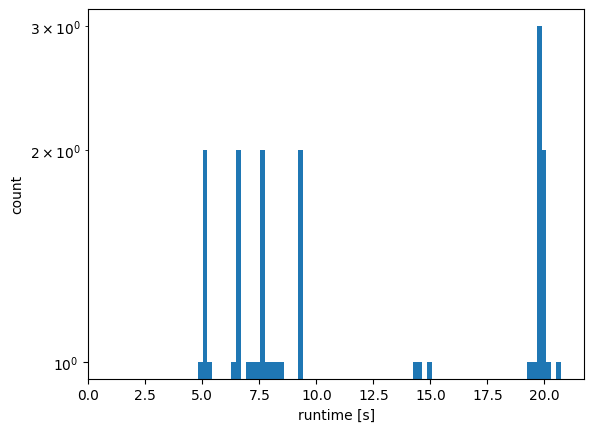

In [8]:
fig, ax = plt.subplots()
bins = np.linspace(0, max(out["runtime"])*1.01, 100)
ax.hist(out["runtime"], bins=bins)
ax.set_xlabel("runtime [s]")
ax.set_xlim([0, ax.get_xlim()[1]])
ax.set_ylabel("count")
ax.semilogy();

Text(0, 0.5, 'runtime [s]')

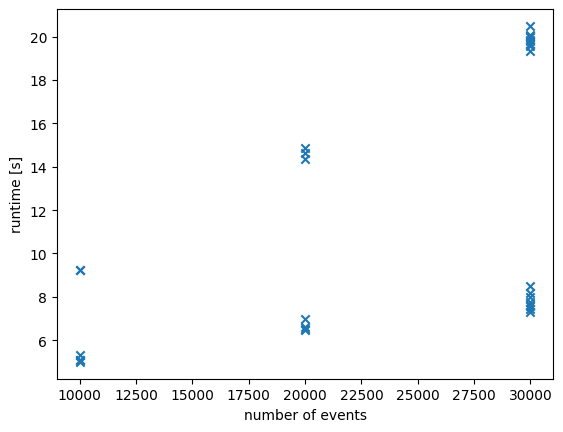

In [9]:
fig, ax = plt.subplots()
ax.scatter(out["num_entries"], out["runtime"], marker="x")
ax.set_xlabel("number of events")
ax.set_ylabel("runtime [s]")

## Using coffea 2024

In [ ]:
BRANCH_LIST = [
    "AnalysisJetsAuxDyn.pt", "AnalysisJetsAuxDyn.eta", "AnalysisJetsAuxDyn.phi", "AnalysisJetsAuxDyn.m",
    "AnalysisElectronsAuxDyn.pt", "AnalysisElectronsAuxDyn.eta", "AnalysisElectronsAuxDyn.phi",
    "AnalysisElectronsAuxDyn.m", "AnalysisMuonsAuxDyn.pt", "AnalysisMuonsAuxDyn.eta",
    "AnalysisMuonsAuxDyn.phi", "AnalysisJetsAuxDyn.EnergyPerSampling", "AnalysisJetsAuxDyn.SumPtTrkPt500",
    "AnalysisJetsAuxDyn.TrackWidthPt1000", "PrimaryVerticesAuxDyn.z", "PrimaryVerticesAuxDyn.x",
    "PrimaryVerticesAuxDyn.y", "AnalysisJetsAuxDyn.NumTrkPt500", "AnalysisJetsAuxDyn.NumTrkPt1000",
    "AnalysisJetsAuxDyn.SumPtChargedPFOPt500", "AnalysisJetsAuxDyn.Timing",
    "AnalysisJetsAuxDyn.JetConstitScaleMomentum_eta", "AnalysisJetsAuxDyn.ActiveArea4vec_eta",
    "AnalysisJetsAuxDyn.DetectorEta", "AnalysisJetsAuxDyn.JetConstitScaleMomentum_phi",
    "AnalysisJetsAuxDyn.ActiveArea4vec_phi", "AnalysisJetsAuxDyn.JetConstitScaleMomentum_m",
    "AnalysisJetsAuxDyn.JetConstitScaleMomentum_pt", "AnalysisJetsAuxDyn.EMFrac",
    "AnalysisJetsAuxDyn.Width", "AnalysisJetsAuxDyn.ActiveArea4vec_m", "AnalysisJetsAuxDyn.ActiveArea4vec_pt",
    "AnalysisJetsAuxDyn.DFCommonJets_QGTagger_TracksWidth", "AnalysisJetsAuxDyn.PSFrac",
    "AnalysisJetsAuxDyn.JVFCorr", "AnalysisJetsAuxDyn.DFCommonJets_QGTagger_TracksC1",
    "AnalysisJetsAuxDyn.DFCommonJets_fJvt", "AnalysisJetsAuxDyn.DFCommonJets_QGTagger_NTracks",
    "AnalysisJetsAuxDyn.GhostMuonSegmentCount", "AnalysisMuonsAuxDyn.muonSegmentLinks",
    "AnalysisMuonsAuxDyn.msOnlyExtrapolatedMuonSpectrometerTrackParticleLink",
    "AnalysisMuonsAuxDyn.extrapolatedMuonSpectrometerTrackParticleLink",
    "AnalysisMuonsAuxDyn.inDetTrackParticleLink", "AnalysisMuonsAuxDyn.muonSpectrometerTrackParticleLink",
    "AnalysisMuonsAuxDyn.momentumBalanceSignificance", "AnalysisMuonsAuxDyn.topoetcone20_CloseByCorr",
    "AnalysisMuonsAuxDyn.scatteringCurvatureSignificance", "AnalysisMuonsAuxDyn.scatteringNeighbourSignificance",
    "AnalysisMuonsAuxDyn.neflowisol20_CloseByCorr", "AnalysisMuonsAuxDyn.topoetcone20",
    "AnalysisMuonsAuxDyn.topoetcone30", "AnalysisMuonsAuxDyn.topoetcone40", "AnalysisMuonsAuxDyn.neflowisol20",
    "AnalysisMuonsAuxDyn.segmentDeltaEta", "AnalysisMuonsAuxDyn.DFCommonJetDr",
    "AnalysisMuonsAuxDyn.combinedTrackParticleLink", "AnalysisMuonsAuxDyn.InnerDetectorPt",
    "AnalysisMuonsAuxDyn.MuonSpectrometerPt", "AnalysisMuonsAuxDyn.clusterLink",
    "AnalysisMuonsAuxDyn.spectrometerFieldIntegral", "AnalysisElectronsAuxDyn.ambiguityLink",
    "AnalysisMuonsAuxDyn.EnergyLoss", "AnalysisJetsAuxDyn.NNJvtPass", "AnalysisElectronsAuxDyn.topoetcone20_CloseByCorr",
    "AnalysisElectronsAuxDyn.topoetcone20ptCorrection", "AnalysisElectronsAuxDyn.topoetcone20",
    "AnalysisMuonsAuxDyn.ptvarcone30_Nonprompt_All_MaxWeightTTVA_pt500_CloseByCorr",
    "AnalysisElectronsAuxDyn.DFCommonElectronsECIDSResult", "AnalysisElectronsAuxDyn.neflowisol20",
    "AnalysisMuonsAuxDyn.ptvarcone30_Nonprompt_All_MaxWeightTTVA_pt500", "AnalysisMuonsAuxDyn.ptcone40",
    "AnalysisMuonsAuxDyn.ptvarcone30_Nonprompt_All_MaxWeightTTVA_pt1000_CloseByCorr",
    "AnalysisMuonsAuxDyn.ptvarcone30_Nonprompt_All_MaxWeightTTVA_pt1000", "AnalysisMuonsAuxDyn.ptvarcone40",
    "AnalysisElectronsAuxDyn.f1", "AnalysisMuonsAuxDyn.ptcone20_Nonprompt_All_MaxWeightTTVA_pt500",
    "PrimaryVerticesAuxDyn.vertexType", "AnalysisMuonsAuxDyn.ptvarcone30", "AnalysisMuonsAuxDyn.ptcone30",
    "AnalysisMuonsAuxDyn.ptcone20_Nonprompt_All_MaxWeightTTVA_pt1000",
    "AnalysisElectronsAuxDyn.ptvarcone30_Nonprompt_All_MaxWeightTTVALooseCone_pt500", "AnalysisMuonsAuxDyn.CaloLRLikelihood"
]

def materialize_branches(events):
    num_events = ak.num(events, axis=0)  # track number of events

    # this will read around 25% of data files
    # materialize branches, just derive integers from them that will be aggregated to avoid memory issues
    _counter = 0
    for branch in BRANCH_LIST:
        obj_name, obj_prop = branch.split(".")
        obj_name = obj_name.replace("Analysis", "").replace("AuxDyn", "")
        if "Link" not in obj_prop:
            branch_data = events[obj_name, obj_prop]
        else:
            branch_data = events[obj_name, obj_prop]["m_persIndex"]

        _counter_to_add = ak.count_nonzero(branch_data, axis=-1)  # reduce innermost

        # reduce >2-dimensional (per event) branches further
        for _ in range(_counter_to_add.ndim - 1):
            _counter_to_add = ak.count_nonzero(_counter_to_add, axis=-1)

        _counter = _counter + _counter_to_add  # sum 1-dim array built from new branch

    _counter = ak.count_nonzero(_counter, axis=0)  # reduce to int

    return {"nevts": num_events, "_counter": _counter}

In [ ]:
%%time
# pre-process
with performance_report(filename="dask-report-preprocess.html"):
    samples, report = dataset_tools.preprocess(fileset, skip_bad_files=True, uproot_options={"allow_read_errors_with_report": True})

In [ ]:
# find issues where access did not work
for process in report:
    for k, v in report[process]["files"].items():
        if v["steps"] is None:
            print(f"could not read {k}")

In [ ]:
%%time
# create the task graph
# filter_name seems to not do anything here in terms of performance
filter_name = lambda name: name in BRANCH_LIST
tasks = dataset_tools.apply_to_fileset(materialize_branches,
                                       samples,
                                       uproot_options={"allow_read_errors_with_report": (OSError, TypeError, KeyError), "filter_name": filter_name},
                                       schemaclass=PHYSLITESchema)

In [ ]:
%%time
# execute task graph
t0 = time.perf_counter()
with performance_report(filename="dask-report-compute.html"):
    ((out, report),) = dask.compute(tasks)  # feels strange that this is a tuple-of-tuple
t1 = time.perf_counter()

print(f"total time spent in uproot reading data: {ak.sum([v['duration'] for v in report.values()]):.2f} s")
print(f"wall time: {t1-t0:.2f}s")

In [ ]:
print(f"output: {out}")

print("\nperformance metrics:")
event_rate = sum([out[process]["nevts"] for process in out.keys()]) / (t1-t0)
print(f" - event rate: {event_rate / 1_000:.2f} kHz")

# need uproot>=5.3.2 to get these useful performance stats
num_bytes = ak.sum([report[process]["performance_counters"]["num_requested_bytes"] for process in out.keys()])
read_MB = num_bytes / 1_000**2
rate_Mbs = read_MB / (t1-t0)
print(f" - read {read_MB:.2f} MB in {t1-t0:.2f} s -> {rate_Mbs*8:.2f} Mbps (need to scale by x{200/8/rate_Mbs*1000:.0f} to reach 200 Gbps)")

In [ ]:
# report problematic files that caused exceptions
for process in report.keys():
    for i_file in range(len(report[process].exception)):
        file_report = report[process][i_file]
        if file_report.exception is not None:
            print(file_report.args[0].strip("\'"))
            print(file_report.message + "\n")

In [ ]:
# sanity check that the right colums are being touched
# dak.report_necessary_columns(tasks)

In [ ]:
# if issues with files exist, paste in path and reproduce
# fname = "root://192.170.240.143//root://fax.mwt2.org:1094//pnfs/uchicago.edu/atlaslocalgroupdisk/rucio/mc20_13TeV/6e/cf/DAOD_PHYSLITE.37230006._000001.pool.root.1"
# treename = "CollectionTree"
# events = NanoEventsFactory.from_root({fname: treename}, schemaclass=PHYSLITESchema).events()
# task = materialize_branches(events)
# task["_counter"].compute()

## Dask distributing `xrdcp`

In [ ]:
# distribute `xrdcp` with Dask
def run_xrdcp(fname):
    t0 = time.perf_counter()
    os.system(f"xrdcp {fname} /dev/null -f")
    t1 = time.perf_counter()
    time_finished = datetime.datetime.now()
    return {"runtime": t1-t0, "time_finished": time_finished}

all_files = []
for process in fileset:
    all_files += fileset[process]["files"]

# perform computation
print(f"running with {len(all_files)} files")

t0 = time.perf_counter()
with performance_report(filename="dask-report-xrdcp.html"):
    futures = client.map(run_xrdcp, all_files)
    out = ak.Array([r for r in client.gather(iter(futures))])
t1 = time.perf_counter()

print(f"wall clock time: {t1-t0:.2f}s")
print(f"current number of workers: {len(client.scheduler_info()['workers'])}")

total_runtime = sum(out["runtime"])
print(f"total aggregated runtime in function: {total_runtime:.2f} s")
print(f"ratio total runtime / wall clock time: {total_runtime / (t1-t0):.2f} "\
      "(should match # cores without overhead / scheduling issues)")